## Predicting developer salaries with Stack Overflow's 2019 Developer Survey

This notebook builds on a previous project where I modelled the salaries of data scientists and data analysts using the StackOverflow developer survey ([project link here](https://github.com/jamie-ralph/data-career-analysis)). My goal here is to use data from all developer types to predict salaries. I'll be focussing the analysis on full-time developers working in industry in the United States who earn between \\$30,000 and \\$300,000. Salaries are converted to log10-salaries because they're distributed in a log-normal way. 

### Import and clean the data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# Read in the results
survey_results = pd.read_csv("survey_results_public.csv")

# Apply filters

df = survey_results[(survey_results['ConvertedComp'] >= 30e3) & 
             (survey_results['ConvertedComp'] <= 30e4) & 
             (survey_results['Country'] == 'United States') &
             (survey_results['Employment'] == 'Employed full-time') &
             (survey_results['YearsCodePro'] != 'More than 50 years')].copy()

### Transform columns

# Log of salary 
df['Log10Salary'] = np.log10(df['ConvertedComp'])

# Make the years of pro coding column a numeric variable
df.loc[df['YearsCodePro'] == 'Less than 1 year', 'YearsCodePro'] = 0

df['YearsCodePro'] = pd.to_numeric(df['YearsCodePro'])

df['Log10YearsCodePro'] = np.log10(df['YearsCodePro'] + 1)

# Log of age
df['Log10Age'] = np.log10(df['Age'])



In [33]:
# Remove managers and academics

managers = df[df['DevType'].str.contains("Engineering manager|Product manager|Senior executive/VP", na = False)]

academic = df[df['DevType'].str.contains("Academic researcher|Scientist|Educator", na = False)]

to_remove = managers.append(academic)

def anti_join(x, y, on):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='left', indicator=True, on=on)
    ans = ans.loc[ans._merge == 'left_only', :].drop(columns='_merge')
    return ans

def anti_join_all_cols(x, y):
    """Return rows in x which are not present in y"""
    assert set(x.columns.values) == set(y.columns.values)
    return anti_join(x, y, x.columns.tolist())

df = anti_join_all_cols(df, to_remove)

In [34]:
# Collapse categorical variables to smaller sets of categories

open_sourcer_dict = {
    "Never": 'Never',
    "Less than once per year": 'Sometimes',
    "Less than once a month but more than once per year": 'Often',
    "Once a month or more often": 'Often'
}

main_branch_dict = {
    "I am a developer by profession": 'professional_dev',
    "I am not primarily a developer, but I write code sometimes as part of my work": 'not_professional_dev'
}

ed_level_dict = {
    "I never completed any formal education": 'Less than bachelors',
    "Primary/elementary school": 'Less than bachelors',
    "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": 'Less than bachelors',
    "Some college/university study without earning a degree": 'Less than bachelors',
    "Associate degree": 'Less than bachelors',
    "Bachelor’s degree (BA, BS, B.Eng., etc.)": 'Bachelors degree',
    "Other doctoral degree (Ph.D, Ed.D., etc.)": 'Graduate degree',
    "Master’s degree (MA, MS, M.Eng., MBA, etc.)": 'Graduate degree',
    "Professional degree (JD, MD, etc.)": 'Graduate degree'
}


df['OpenSourcer'] = df.OpenSourcer.map(open_sourcer_dict)
df['MainBranch'] = df.MainBranch.map(main_branch_dict)
df['EdLevel'] = df.EdLevel.map(ed_level_dict)

df.loc[df['Gender'].str.contains('Non-binary', na = False), 'Gender'] = 'Non-binary_genderqueer_gender-non-conforming'
df.loc[df['Gender'].str.contains('Woman', na = False) & 
       df['Gender'].str.contains('Man', na = False), 'Gender'] = 'Non-binary_genderqueer_gender-non-conforming'

### Explore predictors

#### Step 1 - Compare numerical predictors

The first step is to check for correlation between the outcome and two related numerical predictors: years of professional coding experience (YearsCodePro) and age. Both variables are positively skewed so I'll log-transform them before modelling.  YearsCodePro can be 0 (reported as "Less than 1 year" in the survey") so I'll add 1 and then log-transform to make it normally distributed. We can then check whether this correlates more strongly with log10 salary than log10age, which I used as an indepedent variable in the original project. 

The correlation between log salary and log of years coding professionally is 0.460
The correlation between log salary and log age is 0.311


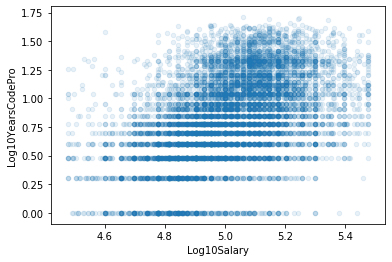

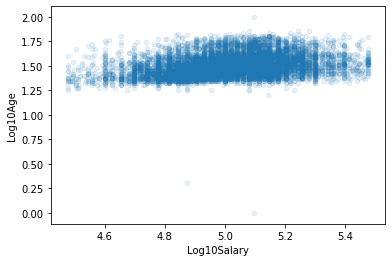

In [35]:
# Choose numeric predictor
from scipy.stats import pearsonr

df_numeric = df[['Log10Age', 'Log10Salary', 'Log10YearsCodePro']].dropna()

corr_code, _ = pearsonr(df_numeric['Log10Salary'], df_numeric['Log10YearsCodePro'])
corr_age, _ = pearsonr(df_numeric['Log10Salary'], df_numeric['Log10Age'])

print("The correlation between log salary and log of years coding professionally is %.3f" % corr_code)
print("The correlation between log salary and log age is %.3f" % corr_age)

df.plot.scatter('Log10Salary', 'Log10YearsCodePro', alpha = 0.1)

df.plot.scatter('Log10Salary', 'Log10Age', alpha = 0.1)


This is great! We've found that years of coding professionally is correlated more strongly with salary than age, so a linear model should work better with this variable. 

#### Step 2 - Check categorical variables

The next step is to check salary ranges across all levels of the categorical variables that I want to use. 

Text(0.5, 0.98, '')

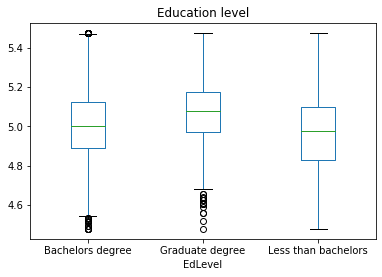

In [36]:
df.boxplot(by = 'EdLevel', column = ['Log10Salary'], grid=False).set_title('Education level')
plt.suptitle('')

Text(0.5, 0.98, '')

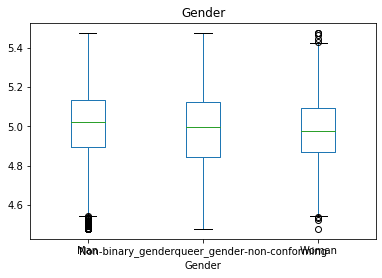

In [37]:
df.boxplot(by = 'Gender', column = ['Log10Salary'], grid=False).set_title('Gender')
plt.suptitle('')

Text(0.5, 0.98, '')

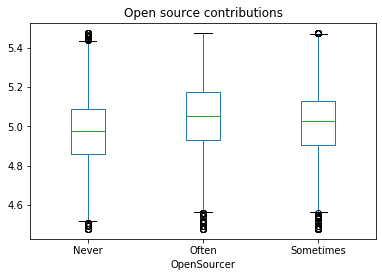

In [38]:
df.boxplot(by = 'OpenSourcer', column = ['Log10Salary'], grid=False).set_title('Open source contributions')
plt.suptitle('')

Text(0.5, 0.98, '')

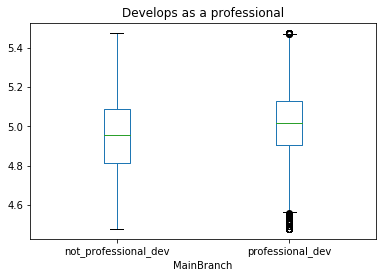

In [39]:
df.boxplot(by = 'MainBranch', column = ['Log10Salary'], grid=False).set_title('Develops as a professional')
plt.suptitle('')

Text(0.5, 0.98, '')

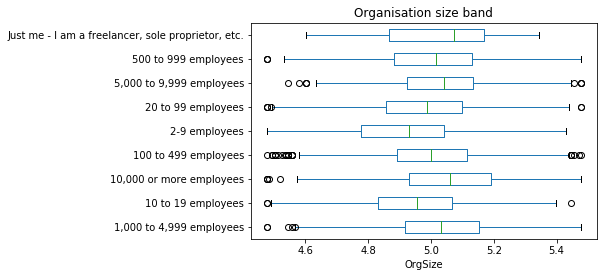

In [40]:
df.boxplot(by = 'OrgSize', column = ['Log10Salary'], grid=False, vert = False).set_title('Organisation size band')
plt.suptitle('')

Based on these boxplots, education level, organisation size, and developing professionally seem to have a larger effect of salary than open source contributions or gender. The approach I will take here will be to include all variables in a random forest regressor, pick out the most important features, and then pass them into a linear regression predictor. 

### Building predictive models
##### Define train and test sets

In [41]:
cat_predictors = ['OpenSourcer', 'EdLevel', 'MainBranch', 'Gender', 'OrgSize']

num_predictors = ['Log10YearsCodePro']

model_df = df[cat_predictors + num_predictors + ['Log10Salary']].dropna()


RANDOM_STATE = 49

train_df, test_df = train_test_split(model_df, test_size = 0.2, random_state = RANDOM_STATE)

train_y = train_df['Log10Salary'].copy()
train_X = train_df.drop("Log10Salary", axis = 1)

test_y = test_df['Log10Salary'].copy()
test_X = test_df.drop("Log10Salary", axis = 1)

##### Define pipeline

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


full_pipe = ColumnTransformer([
    ("numerical", StandardScaler(), num_predictors),
    ("categorical", OneHotEncoder(), cat_predictors)
])

train_X_prepared = full_pipe.fit_transform(train_X)
test_X_prepared = full_pipe.transform(test_X)

#### Random forest 

In [43]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

grid = GridSearchCV(
    estimator = RandomForestRegressor(),
    param_grid = {
        'max_depth': range(4, 11),
        'n_estimators': (3, 10, 30, 50, 70, 90, 110)
    },
    cv = 10, scoring = 'neg_mean_squared_error', verbose = 0, n_jobs = -1)

grid_results = grid.fit(train_X_prepared, train_y)


The random forest model RMSE is 0.145


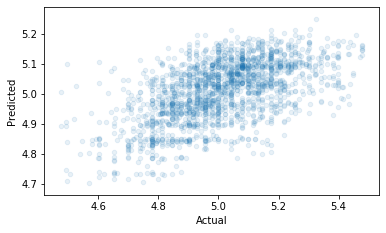

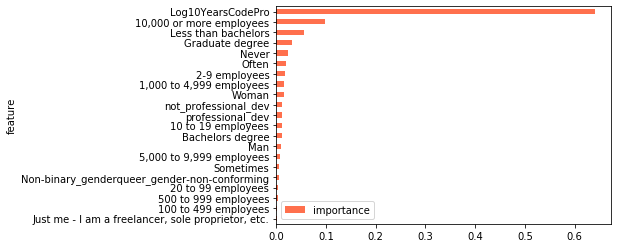

In [47]:
from sklearn.metrics import mean_squared_error

predictions_rf = grid_results.best_estimator_.predict(test_X_prepared)

result_rf = pd.DataFrame({'Actual': test_y, 'Predicted': predictions_rf})

rf_plot = result_rf.plot.scatter("Actual", "Predicted", alpha = 0.1)
rf_plot.set_aspect('equal')

rf_reg_mse = mean_squared_error(test_y, predictions_rf)
rf_reg_rmse = np.sqrt(rf_reg_mse)

print("The random forest model RMSE is %.3f" % rf_reg_rmse)

# Plot variable importance

feature_imp = grid_results.best_estimator_.feature_importances_
cat_encoder = full_pipe.named_transformers_['categorical']

categories = []
for sublist in cat_encoder.categories_:
    for item in sublist:
        categories.append(item)

features = ['Log10YearsCodePro'] + categories
        
features_df = pd.DataFrame({'feature': features, 'importance': feature_imp})        

features_df = features_df.sort_values(by = 'importance')

features_df.plot(x = 'feature', y = 'importance', kind = 'barh', color = '#ff704d')


#### Linear regression model

Based on the feature importance scores from the random forest, the most useful features for predicting salaries will be years of professional coding, organisation size, and education level. I'll re-define the train/test sets and the ML pipeline before running a linear regression. 

In [48]:
cat_predictors = ['EdLevel', 'OrgSize']

num_predictors = ['Log10YearsCodePro']

model_df = df[cat_predictors + num_predictors + ['Log10Salary']].dropna()


RANDOM_STATE = 49

train_df, test_df = train_test_split(model_df, test_size = 0.2, random_state = RANDOM_STATE)

train_y = train_df['Log10Salary'].copy()
train_X = train_df.drop("Log10Salary", axis = 1)

test_y = test_df['Log10Salary'].copy()
test_X = test_df.drop("Log10Salary", axis = 1)

The linear regression model RMSE is 0.147


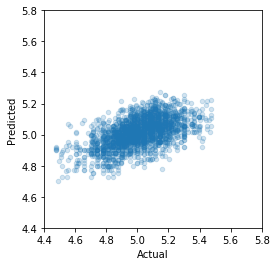

In [49]:
from sklearn.linear_model import LinearRegression

# Redefine pipeline
full_pipe = ColumnTransformer([
    ("numerical", StandardScaler(), ['Log10YearsCodePro']),
    ("categorical", OneHotEncoder(), ['EdLevel', 'OrgSize'])
])

train_X_prepared = full_pipe.fit_transform(train_X)

# Fit model to training set
lin_reg = LinearRegression()
lin_reg.fit(train_X_prepared, train_y)

# Calculate RMSE on test set and plot predicted vs. actual values

test_X_prepared = full_pipe.transform(test_X)
predictions = lin_reg.predict(test_X_prepared)
result_lin_reg = pd.DataFrame({'Actual': test_y, 'Predicted': predictions})

lin_reg_mse = mean_squared_error(test_y, predictions)
lin_reg_rmse = np.sqrt(lin_reg_mse)

print("The linear regression model RMSE is %.3f" % lin_reg_rmse)
lin_plot = result_lin_reg.plot.scatter("Actual", "Predicted",
                                       xlim = [4.4, 5.8], ylim = [4.4, 5.8], alpha = 0.2)
lin_plot.set_aspect('equal')





#### Conclusion




In this notebook I used random forest and linear regression to predict developer salaries. Years of professional coding, organisation size, and education level emerged as the most important feature for modelling. The random forest regressor had a smaller average error than simple linear regression. 